In [8]:
import os
import numpy
import cv2
import matplotlib.pyplot
from PIL import Image
from tensorflow import keras
import tensorflow
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, BatchNormalization, Activation, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.python.client import device_lib
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import random
# from sklearn.model_selection import train_test_split
import sklearn.model_selection

In [2]:
# width = 1640
width_standard= 1640
height_standard = 590
# width = 1152
# height = 192

width = 512
height = 128

In [3]:
fileTrain = "./DataTrain"
fileVal = "./DataVal"
fileSaveTrain = "./DataClean/Train"
fileSaveVal = "./DataClean/Val"
fileSave = "./DataClean"

fileXTrain = "./DataClean/Train/X"
fileYTrain = "./DataClean/Train/Y"
fileXVal = "./DataClean/Val/X"
fileYVal = "./DataClean/Val/Y"

fileDiscriminatorRaw = "./DataDiscriminator/Raw"
fileDataDiscriminatorTrue = "./DataDiscriminator/DataTrue"

fileDataDiscriminatorXTrue = "./DataDiscriminator/DataTrue/X"
fileDataDiscriminatorYTrue = "./DataDiscriminator/DataTrue/Y"
fileDataDiscriminatorPredict = "./DataDiscriminator/DataFalse"

In [16]:
def read_data_file(path, standardize = False):
    images = []
    for file in os.listdir(path):
        file_name = os.path.join(path, file)
        # print(file_name)
        if (".jpg" in file):
            img = numpy.array(Image.open(file_name)).astype(numpy.float32)
            if (standardize):
                img_stand = img / 255
                images.append(img_stand)
                del img_stand
                del img
                continue
            images.append(img)
            del img
            # matplotlib.pyplot.imshow(img)
            # matplotlib.pyplot.show()
    return images

In [14]:
TestX = read_data_file(fileDataDiscriminatorXTrue)
TestY = read_data_file(fileDataDiscriminatorYTrue) + read_data_file(fileDataDiscriminatorPredict, True)
# TestY = read_data_file(fileDataDiscriminatorYTrue)
# TestY = read_data_file(fileDataDiscriminatorPredict, True)

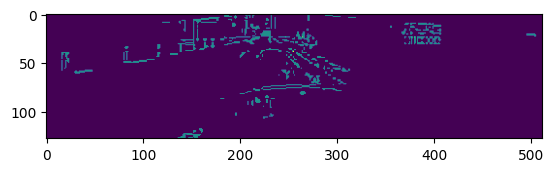

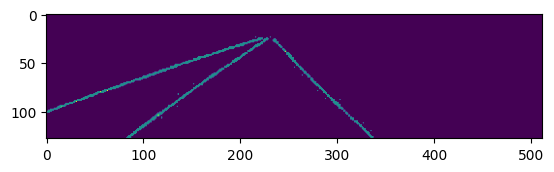

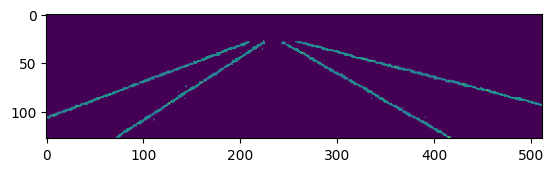

In [18]:
matplotlib.pyplot.imshow(TestX[0])
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(TestY[0])
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(TestY[int(len(TestY) / 2) + -1])
matplotlib.pyplot.show()

In [17]:
numpy.set_printoptions(threshold=numpy.inf)
print(TestY[0])

[[0.00784314 0.03137255 0.00392157 0.01568628 0.01960784 0.03529412
  0.         0.01960784 0.         0.03137255 0.01568628 0.01960784
  0.02352941 0.02352941 0.         0.02745098 0.         0.02745098
  0.00392157 0.01176471 0.01176471 0.03137255 0.00392157 0.02352941
  0.         0.03921569 0.00392157 0.02745098 0.00784314 0.02745098
  0.         0.02352941 0.00392157 0.01568628 0.00784314 0.02745098
  0.13725491 0.02745098 0.00392157 0.01960784 0.         0.01960784
  0.         0.03137255 0.2        0.03137255 0.         0.02352941
  0.00392157 0.01960784 0.         0.02352941 0.         0.03137255
  0.         0.01568628 0.00392157 0.01960784 0.00392157 0.03137255
  0.         0.02745098 0.01176471 0.01568628 0.00392157 0.01568628
  0.         0.02745098 0.         0.02352941 0.01176471 0.01960784
  0.00784314 0.02745098 0.         0.02352941 0.00392157 0.02352941
  0.         0.02352941 0.00784314 0.01960784 0.00784314 0.01960784
  0.32941177 0.02352941 0.         0.02352941 0.

In [20]:
TestX.extend(TestX)

In [33]:
if (len(TestX) != len(TestY)):
    print(len(TestX))
    print(len(TestY))
    print("Error")

In [34]:
label = []
length = int(len(TestY) / 2)

for i in range(length):
    label.append(0)
for i in range(length):
    label.append(1)
print(len(TestX))
print(len(TestY))
print(len(label))


15382
15382
15382


In [23]:

discriminatorData = [TestX, TestY, label]


In [24]:
discriminatorData = [list(row) for row in zip(*discriminatorData)]
random.shuffle(discriminatorData)

In [25]:
discriminatorTrain, discriminatorVal = sklearn.model_selection.train_test_split(discriminatorData, test_size=0.3)

In [26]:
discriminatorTrain = [list(row) for row in zip(*discriminatorTrain)]
discriminatorVal = [list(row) for row in zip(*discriminatorVal)]

In [28]:
print(len(discriminatorTrain))
print(len(discriminatorVal))

3
3


In [29]:
def _discriminator():
    init = RandomNormal(stddev=0.02)

    input_image = Input(shape=(height, width, 1))
    input_target = Input(shape=(height, width, 1))
    merge = Concatenate()([input_image, input_target])

    d = Conv2D(8, (4,4), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(merge)
    d = BatchNormalization()(d, training=True)
    d = Conv2D(16, (4,4), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = Conv2D(32, (4,4), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = Conv2D(512, (4,4), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    # d = Conv2D(1, (4,4), padding='same', activation='sigmoid', kernel_initializer=init)(d)
    d = Flatten()(d)
    d = Dense(2048, activation='relu')(d)
    d = Dense(512, activation='relu')(d)
    d = Dense(128, activation='relu')(d)
    d = Dense(32, activation='relu')(d)
    d = Dense(8, activation='relu')(d)
    d = Dense(1, activation='softmax')(d)

    model = Model([input_image, input_target], d)

    return model

discriminator = _discriminator()
discriminator.summary()

discriminator.compile(optimizer = Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', loss_weights=[0.5], metrics=['accuracy'])

c:\Users\toang\miniconda3\envs\AI\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 512, 2)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

c:\Users\toang\miniconda3\envs\AI\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
print(type(TestX[0]))
print(TestX[0].shape)
print(TestX[0])

<class 'numpy.ndarray'>
(128, 512)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
history = discriminator.fit(x=[numpy.array(discriminatorTrain[0]), numpy.array(discriminatorTrain[1])], 
                  y=numpy.array(discriminatorTrain[2]), 
                  validation_data=([numpy.array(discriminatorVal[0]), numpy.array(discriminatorVal[1])], numpy.array(discriminatorVal[2])),
                  epochs=2, 
                  batch_size=8)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
print(loss)
print(val_loss)
print(accuracy)
print(val_accuracy)
print(epochs)


[0.4376286268234253, 0.1285790652036667]
[0.6242266297340393, 1.3577073812484741]
[1.0, 1.0]
[0.0, 0.0]
range(1, 3)


In [ ]:
final_accuracy = history.history['val_accuracy'][-1]
final_accuracy

0.0

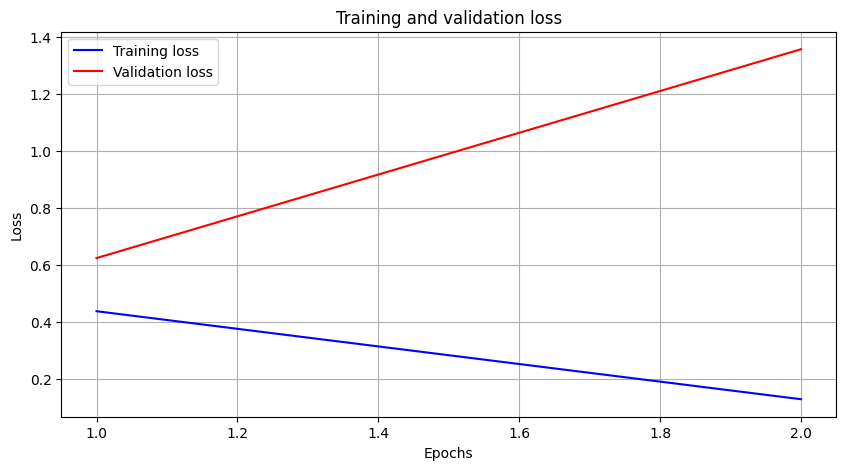

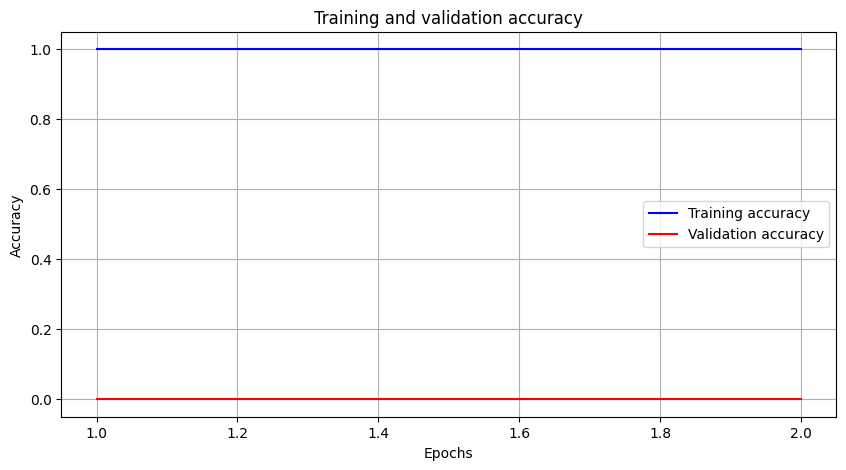

In [ ]:
matplotlib.pyplot.figure(figsize=(10, 5))
matplotlib.pyplot.plot(epochs, loss, 'b', label='Training loss')
matplotlib.pyplot.plot(epochs, val_loss, 'r', label='Validation loss')
matplotlib.pyplot.title('Training and validation loss')
matplotlib.pyplot.xlabel('Epochs')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.legend()
matplotlib.pyplot.grid(True)

matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize=(10, 5))
matplotlib.pyplot.plot(epochs, accuracy, 'b', label='Training accuracy')
matplotlib.pyplot.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
matplotlib.pyplot.title('Training and validation accuracy')
matplotlib.pyplot.xlabel('Epochs')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.legend()
matplotlib.pyplot.grid(True)

matplotlib.pyplot.show()

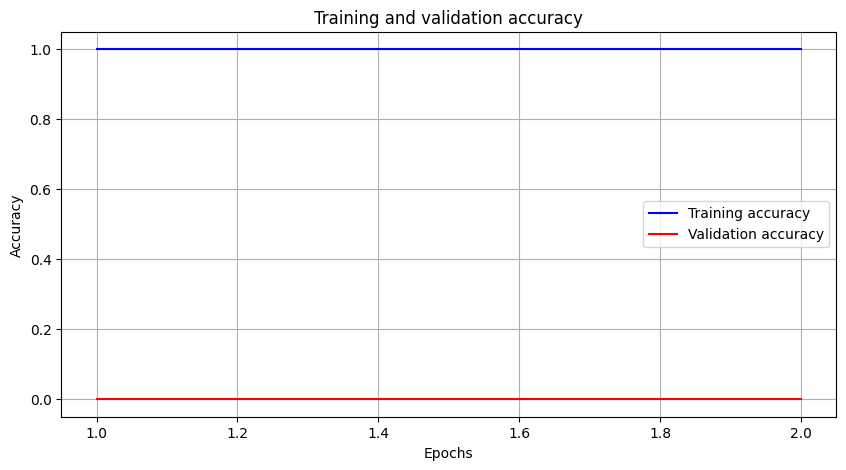

In [ ]:
# Vẽ biểu đồ accuracy
matplotlib.pyplot.figure(figsize=(10, 5))
matplotlib.pyplot.plot(epochs, accuracy, 'b', label='Training accuracy')
matplotlib.pyplot.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
matplotlib.pyplot.title('Training and validation accuracy')
matplotlib.pyplot.xlabel('Epochs')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.legend()
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()

In [ ]:
# discriminator.save('discriminator_val-acc-' + str( round(history.history['val_accuracy'][-1], 3)) + '.h5')

In [ ]:
arr = [[1,2,3], [4,5,6], [7,8,9]]
arr = [list(row) for row in zip(*arr)]
arr = [list(row) for row in zip(*arr)]
# random.shuffle(arr)
# train_data, val_data = sklearn.model_selection.train_test_split(arr, test_size=0.1)
# # train_data, val_data = train_test_split(arr, test_size=0.1)
# print(train_data)
print(arr)


[[1, 2, 3], [4, 5, 6], [7, 8, 9]]


In [9]:

width = 512
height = 128


def _discriminator():
    init = RandomNormal(stddev=0.02)

    input_image = Input(shape=(height, width, 1))
    input_target = Input(shape=(height, width, 1))
    merge = Concatenate()([input_image, input_target])

    d = Conv2D(8, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(merge) 
    d = Dropout(0.1)(d)
    d = MaxPooling2D((2, 2))(d)
    d = BatchNormalization()(d, training=True)

    d = Conv2D(16, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = Dropout(0.2)(d)
    d = MaxPooling2D((2, 2))(d)
    d = BatchNormalization()(d, training=True)

    d = Conv2D(32, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = Dropout(0.2)(d)
    d = MaxPooling2D((2, 2))(d)
    d = BatchNormalization()(d, training=True)
    
    d = Conv2D(64, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = Dropout(0.25)(d)
    d = MaxPooling2D((2, 2))(d)
    d = BatchNormalization()(d, training=True)
    
    d = Conv2D(128, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = Dropout(0.25)(d)
    d = MaxPooling2D((2, 2))(d)
    d = BatchNormalization()(d, training=True)
    
    d = Conv2D(256, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = Dropout(0.3)(d)
    d = MaxPooling2D((2, 2))(d)

    d = Conv2D(512, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(d)
    d = MaxPooling2D((2, 2))(d)
    # d = Conv2D(1, (3,3), padding='same', activation='sigmoid', kernel_initializer=init)(d)
    d = Flatten()(d)
    d = Dense(2048, activation='relu')(d)
    d = Dense(512, activation='relu')(d)
    d = Dense(128, activation='relu')(d)
    d = Dense(32, activation='relu')(d)
    d = Dense(8, activation='relu')(d)
    d = Dense(1, activation='sigmoid')(d)

    model = Model([input_image, input_target], d)

    return model

discriminator = _discriminator()
discriminator.summary()

c:\Users\toang\miniconda3\envs\AI\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 512, 2)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']            